In [2]:
import geowombat as gw

In [3]:
from geowombat.data import rgbn, rgbn_suba, rgbn_subb

In [ ]:
with gw.open(rgbn_suba, band_names=['b', 'g', 'r', 'n']) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open(rgbn_subb, band_names=['b', 'g', 'r', 'n']) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open([rgbn_suba, rgbn_subb], band_names=['b', 'g', 'r', 'n'], mosaic=True) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open([rgbn_suba, rgbn_subb, rgbn_subb], 
             time_names=[1, 1, 2], 
             band_names=['b', 'g', 'r', 'n']) as ds:
    
    ds.sel(time=1).gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, aligned_target
from rasterio.crs import CRS

In [ ]:
with rasterio.open(rgbn) as src:
    
    transform, width, height = calculate_default_transform(src.crs,
                                                           CRS.from_epsg(4326),
                                                           src.width,
                                                           src.height,
                                                           *src.bounds,
                                                           dst_width=src.width,
                                                           dst_height=src.height)
    
    print(width, height)
    res = (transform[0], -transform[4])
    
    print(res)
    
    dst_transform, dst_width, dst_height = aligned_target(transform, width, height, res)
    
    print(dst_transform)
    print(dst_width, dst_height)

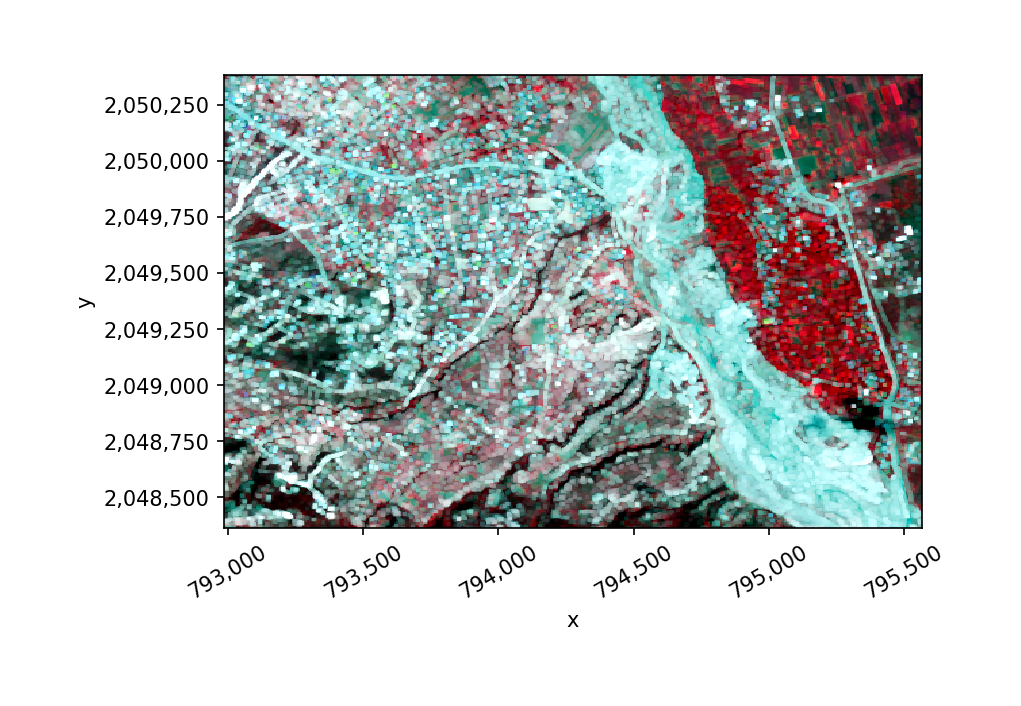

In [24]:
with gw.config.update(sensor='rgbn', ref_res=(5, 5)):

    with gw.open(rgbn, band_names=['b', 'g', 'r', 'n'], resampling='cubic') as ds:

        dss = ds.gw.moving(stat='max', n_jobs=8)

        dss.gw.imshow(band_names=['g', 'r', 'n'], flip=True, mask=True, nodata=0, robust=True)

<xarray.DataArray (band: 4, y: 404, x: 516)>
dask.array<open_rasterio-ed8eee959342dbc17e0e9878346d2e40<this-array>, shape=(4, 404, 516), dtype=uint8, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U1 'b' 'g' 'r' 'n'
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
Attributes:
    transform:   (5.0, 0.0, 792985.0, 0.0, -5.0, 2050385.0)
    crs:         +init=epsg:32618
    res:         (5.0, 5.0)
    is_tiled:    1
    nodatavals:  (nan, nan, nan, nan)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)


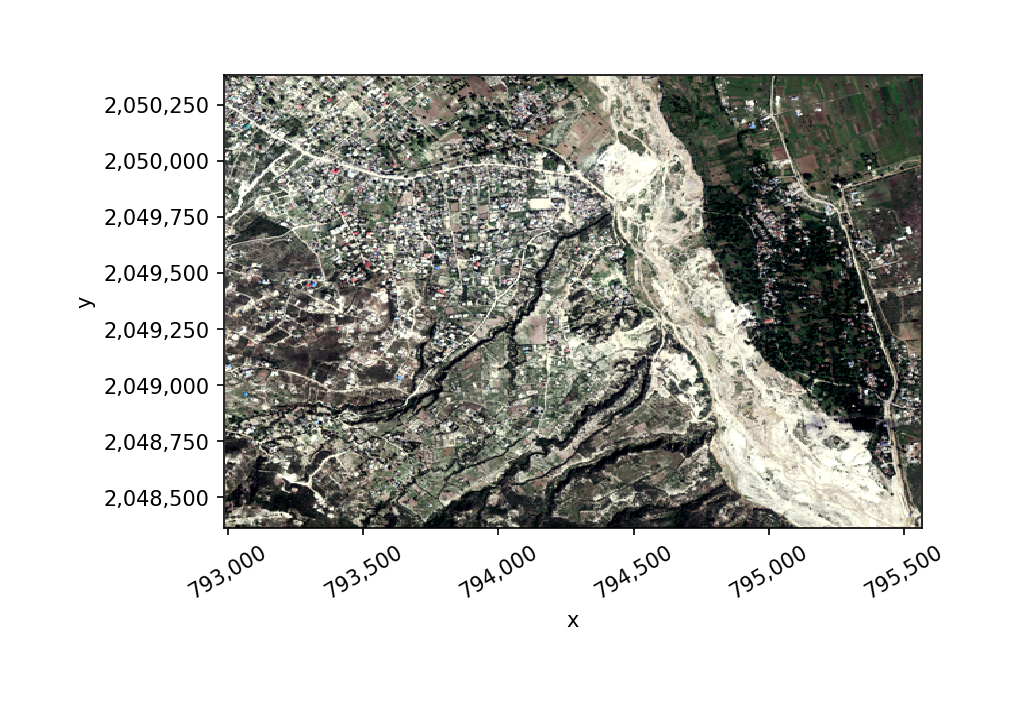

In [17]:
with gw.config.update(sensor='rgbn', ref_res=(5, 5)):

    with gw.open(rgbn, 
                 band_names=['b', 'g', 'r', 'n'],
                 resampling='cubic') as ds:
        
        print(ds)
        ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)